# Veri Ön İşleme

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [4]:
df = pd.read_csv('teen_e_safety_dataset.csv')

In [5]:
df = df.dropna(subset=["Cybersecurity_Behavior_Category"])
df = df.drop(columns=["Timestamp", "Geolocation", "Age_Group"], errors='ignore')

df = df[df["Cybersecurity_Behavior_Category"] != "Neutral"]
df["Binary_Behavior"] = df["Cybersecurity_Behavior_Category"].apply(lambda x: 1 if x == "Safe" else 0)

Hedef Değişkenin Sınıf Dağılım SMOTE öncesi

<ipython-input-6-2767729517>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Binary_Behavior", palette="pastel")


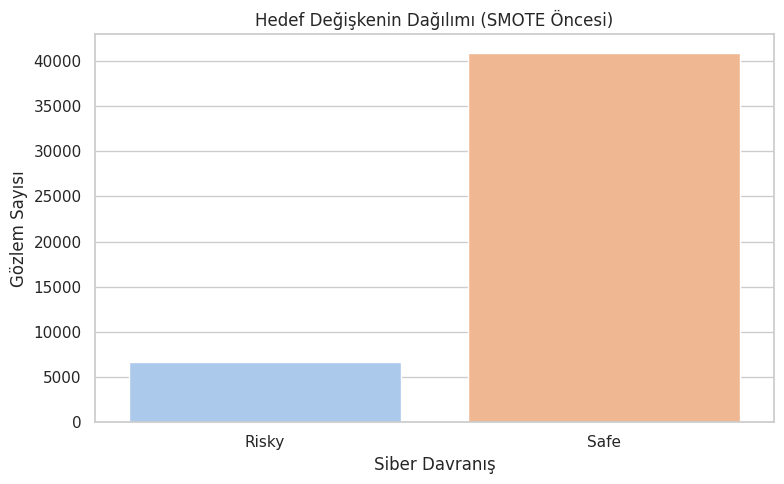

In [6]:
sns.countplot(data=df, x="Binary_Behavior", palette="pastel")
plt.title("Hedef Değişkenin Dağılımı (SMOTE Öncesi)")
plt.xticks([0, 1], ["Risky", "Safe"])
plt.xlabel("Siber Davranış")
plt.ylabel("Gözlem Sayısı")
plt.tight_layout()
plt.show()

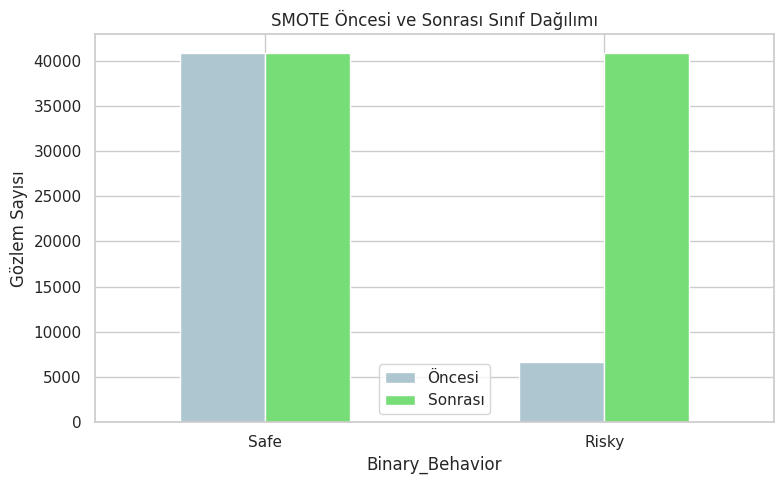

In [12]:
X = df.drop(columns=["Cybersecurity_Behavior_Category", "Binary_Behavior"])
y = df["Binary_Behavior"]

X = pd.get_dummies(X, drop_first=True)

# SMOTE öncesi dağılım
before = y.value_counts()

# SMOTE uygulama
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# SMOTE sonrası dağılım
after = pd.Series(y_res).value_counts()

df_counts = pd.DataFrame({"Öncesi": before, "Sonrası": after})
df_counts.plot(kind="bar", rot=0, color=["#aec6cf", "#77dd77"])
plt.title("SMOTE Öncesi ve Sonrası Sınıf Dağılımı")
plt.xticks([0, 1], ["Safe", "Risky"])
plt.ylabel("Gözlem Sayısı")
plt.tight_layout()
plt.show()

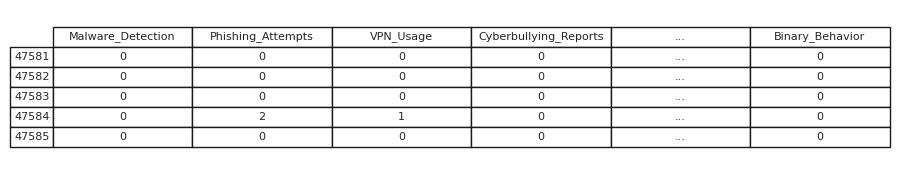

In [15]:
from pandas.plotting import table

original_len = len(df)

X_res_df = pd.DataFrame(X_res, columns=X.columns)
y_res_df = pd.Series(y_res, name="Binary_Behavior")

# SMOTE ile gelen veriler
X_new = X_res_df.iloc[original_len:]
y_new = y_res_df.iloc[original_len:]

# Birleştir
df_new = pd.concat([X_new, y_new], axis=1)

# İlk 5 örnek
df_new.head(5)

df_sample = df_new.head(5).copy()

max_visible = 4
visible_cols = df_sample.columns[:max_visible].tolist() + ["..."] + [df_sample.columns[-1]]
shortened_df = df_sample.iloc[:, :max_visible].copy()
shortened_df["..."] = "..."
shortened_df[df_sample.columns[-1]] = df_sample[df_sample.columns[-1]]

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis("off")

tbl = table(ax, shortened_df.round(2), loc="center", cellLoc="center", colWidths=[0.15]*len(shortened_df.columns))

tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.2, 1.2)

plt.savefig("smote_ozet_tablo.png", dpi=300, bbox_inches="tight")
plt.show()



#**Modelleme Süreci**



## 0. Aşama Korelasyon Matrisi ve XGBoost Feature Importance

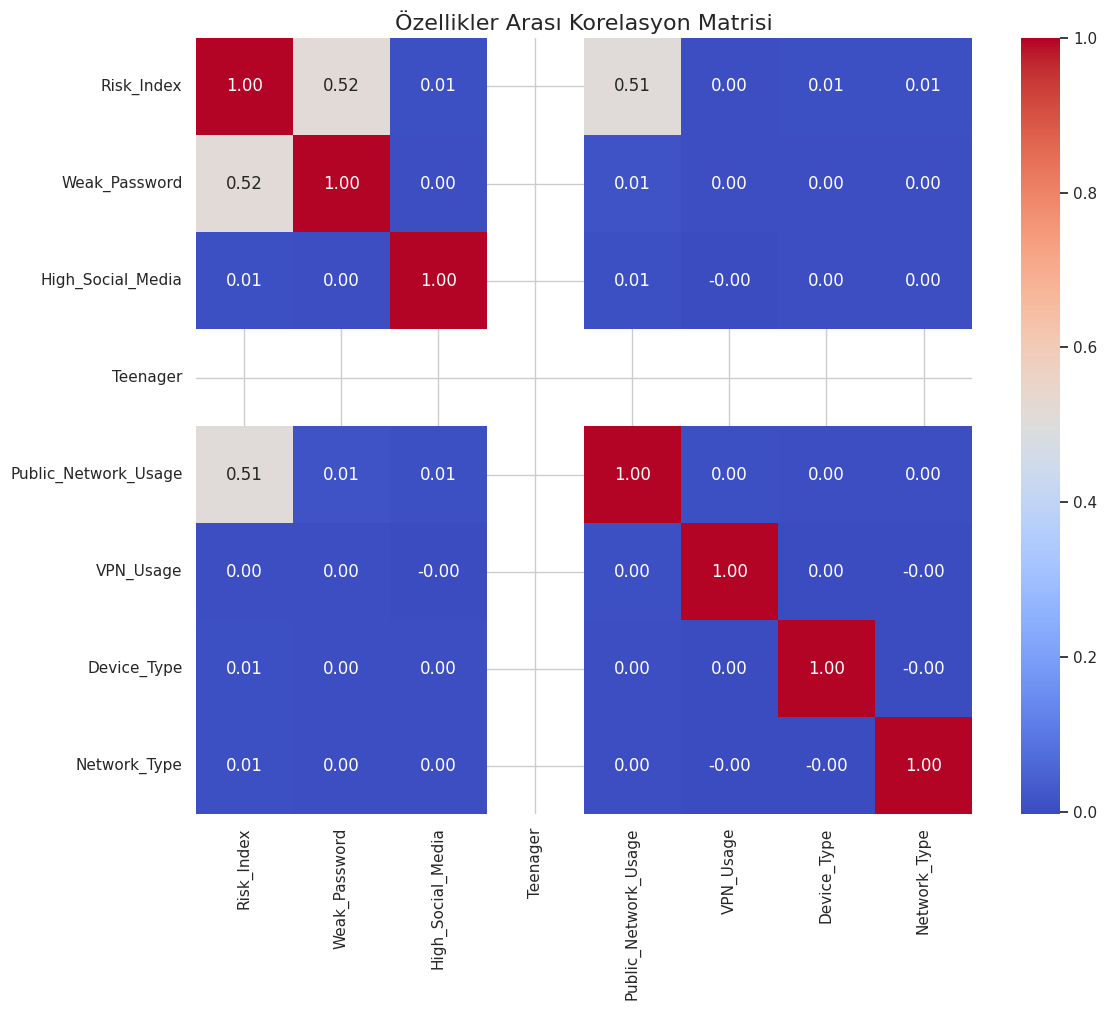

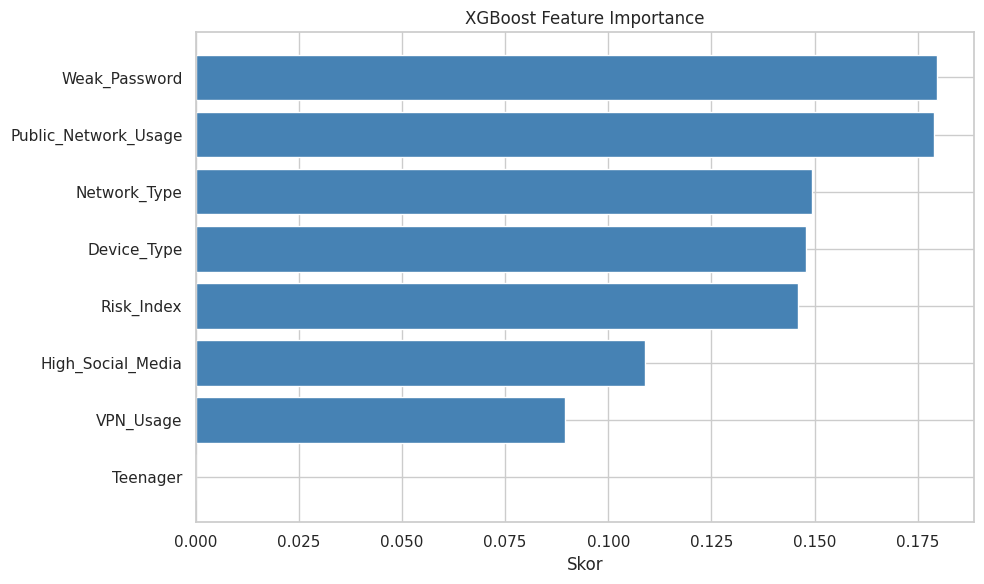

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df = pd.read_csv("teen_e_safety_dataset.csv")

df['Weak_Password'] = (df['Password_Strength'] == 'Weak').astype(int)
df['High_Social_Media'] = (df['Social_Media_Usage'] == 'High').astype(int)
df['Teenager'] = df['Age_Group'].apply(lambda x: 0 if x == 'Under 13' else 1)
df['Risk_Index'] = (
    df['Risky_Website_Visits']
    + df['Ad_Clicks']
    + df['Public_Network_Usage']
    + df['Weak_Password']
    + df['Unencrypted_Traffic']
)

df_binary = df[df['Cybersecurity_Behavior_Category'].isin(['Safe', 'Risky'])].copy()
df_binary['Binary_Behavior'] = LabelEncoder().fit_transform(df_binary['Cybersecurity_Behavior_Category'])

features = [
    "Risk_Index", "Weak_Password",
    "High_Social_Media", "Teenager",
    "Public_Network_Usage", "VPN_Usage", "Device_Type", "Network_Type"
]

df_model = df_binary[features + ['Binary_Behavior']].dropna()
for col in df_model.select_dtypes(include='object').columns:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

X = df_model.drop(columns=['Binary_Behavior'])
y = df_model['Binary_Behavior']

plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Özellikler Arası Korelasyon Matrisi", fontsize=16)
plt.tight_layout()
plt.show()

X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = XGBClassifier(random_state=42, eval_metric='logloss')
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_names = X.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], color="#4682B4")
plt.xlabel("Skor")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

## 1. Aşama XGBoost (Hedef Değişken 3 Sınıflı)

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv("teen_e_safety_dataset.csv")

target = "Cybersecurity_Behavior_Category"
selected_features = [
    "Device_Type", "VPN_Usage", "Password_Strength", "Age_Group",
    "Public_Network_Usage", "Network_Type", "Social_Media_Usage"
]

df = df[selected_features + [target]].dropna()

for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=[target])
y = df[target]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

xgb = XGBClassifier(
    random_state=42,
    objective='multi:softprob',
    num_class=len(y.unique()),
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.41      0.39      8306
           1       0.37      0.48      0.42      7911
           2       0.39      0.24      0.30      8314

    accuracy                           0.37     24531
   macro avg       0.38      0.38      0.37     24531
weighted avg       0.38      0.37      0.37     24531



**Sonuç**

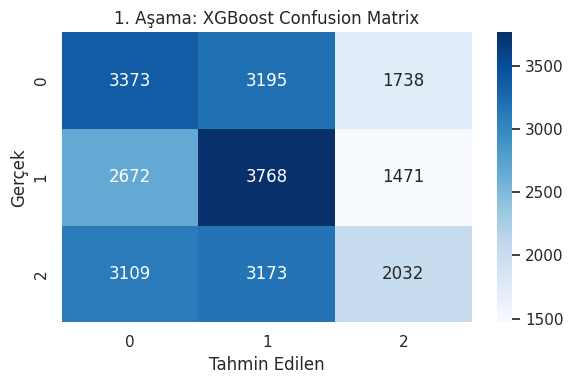

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=xgb.classes_, yticklabels=xgb.classes_)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("1. Aşama: XGBoost Confusion Matrix")
plt.tight_layout()
plt.show()

## 2. Aşama XGBoost + Feature Engineering (Hedef Değişken 2 Sınıflı)

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("teen_e_safety_dataset.csv")

df["Binary_Behavior"] = df["Cybersecurity_Behavior_Category"].apply(lambda x: 1 if x == "Risky" else 0)

df["Weak_Password"] = df["Password_Strength"].apply(lambda x: 1 if x == "Weak" else 0)

df["High_Social_Media"] = df["Social_Media_Usage"].apply(lambda x: 1 if x == "High" else 0)

teen_ages = ["13-16", "17-19"]
df["Teenager"] = df["Age_Group"].apply(lambda x: 1 if x in teen_ages else 0)

df["Risk_Index"] = (
    df["Risky_Website_Visits"] +
    df["Ad_Clicks"] +
    df["Public_Network_Usage"] +
    df["Weak_Password"] +
    df["Unencrypted_Traffic"]
)

selected_features = [
    "Device_Type", "VPN_Usage", "Teenager", "Weak_Password", "High_Social_Media",
    "Public_Network_Usage", "Network_Type", "Risk_Index"
]

df = df[selected_features + ["Binary_Behavior"]].dropna()

for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Binary_Behavior"])
y = df["Binary_Behavior"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.48      0.51     12369
           1       0.53      0.60      0.56     12121

    accuracy                           0.54     24490
   macro avg       0.54      0.54      0.54     24490
weighted avg       0.54      0.54      0.54     24490



**Sonuç**

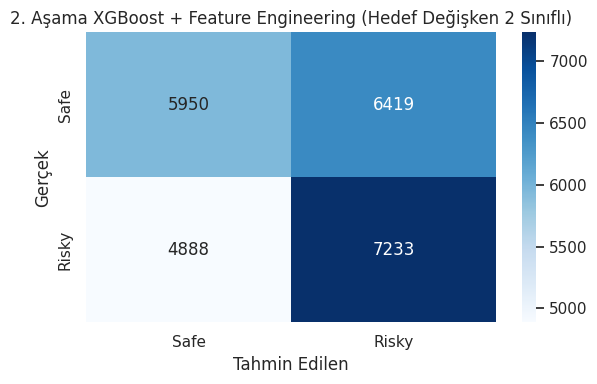

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Safe", "Risky"], yticklabels=["Safe", "Risky"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("2. Aşama XGBoost + Feature Engineering (Hedef Değişken 2 Sınıflı)")
plt.tight_layout()
plt.show()

## 3. Aşama: Ensemble (StackingClassifier) Confusion Matrix

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("teen_e_safety_dataset.csv")

df["Binary_Behavior"] = df["Cybersecurity_Behavior_Category"].apply(lambda x: 1 if x == "Risky" else 0)

df["Weak_Password"] = df["Password_Strength"].apply(lambda x: 1 if x == "Weak" else 0)
df["High_Social_Media"] = df["Social_Media_Usage"].apply(lambda x: 1 if x == "High" else 0)
df["Teenager"] = df["Age_Group"].apply(lambda x: 1 if x in ["13-16", "17-19"] else 0)
df["Risk_Index"] = (
    df["Risky_Website_Visits"] +
    df["Ad_Clicks"] +
    df["Public_Network_Usage"] +
    df["Weak_Password"] +
    df["Unencrypted_Traffic"]
)

selected_features = [
    "Device_Type", "VPN_Usage", "Teenager", "Weak_Password", "High_Social_Media",
    "Public_Network_Usage", "Network_Type", "Risk_Index"
]

df = df[selected_features + ["Binary_Behavior"]].dropna()

for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=["Binary_Behavior"])
y = df["Binary_Behavior"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

base_learners = [
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('rf', RandomForestClassifier(random_state=42))
]
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    cv=5
)

stack_model.fit(X_train, y_train)

y_pred = stack_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.55      0.55     12369
           1       0.54      0.54      0.54     12121

    accuracy                           0.55     24490
   macro avg       0.55      0.55      0.55     24490
weighted avg       0.55      0.55      0.55     24490



**Sonuç**

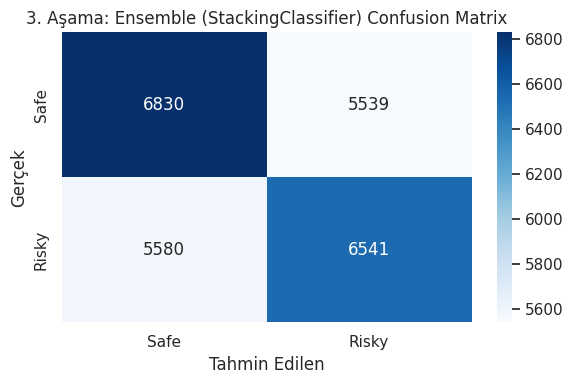

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Safe", "Risky"], yticklabels=["Safe", "Risky"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("3. Aşama: Ensemble (StackingClassifier) Confusion Matrix")
plt.tight_layout()
plt.show()

## 4. Aşama Kümeye Dayalı Veri Temizleme ve XGBoost

In [23]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

df = pd.read_csv("teen_e_safety_dataset.csv")

df['Weak_Password'] = (df['Password_Strength'] == 'Weak').astype(int)
df['High_Social_Media'] = (df['Social_Media_Usage'] == 'High').astype(int)
df['Teenager'] = df['Age_Group'].apply(lambda x: 0 if x == 'Under 13' else 1)
df['Risk_Index'] = (
    df['Risky_Website_Visits']
    + df['Ad_Clicks']
    + df['Public_Network_Usage']
    + df['Weak_Password']
    + df['Unencrypted_Traffic']
)
df['Suspicious_Flag'] = (
    (df['Insecure_Login_Attempts'] > 0)
    | (df['Unencrypted_Traffic'] == 1)
    | (df['Risky_Website_Visits'] == 1)
).astype(int)
df['Download_And_Purchase_Risk'] = df['Download_Risk'] + df['Online_Purchase_Risk']
df['VPN_WeakPW_Interaction'] = ((df['VPN_Usage'] == 0) & (df['Weak_Password'] == 1)).astype(int)
df['Social_Age_Cross'] = df['High_Social_Media'] * df['Teenager']

df_binary = df[df['Cybersecurity_Behavior_Category'].isin(['Safe', 'Risky'])].copy()
df_binary['Binary_Behavior'] = LabelEncoder().fit_transform(df_binary['Cybersecurity_Behavior_Category'])

cluster_features = [
    "Risk_Index", "Suspicious_Flag", "Weak_Password",
    "High_Social_Media", "Teenager", "Download_And_Purchase_Risk",
    "VPN_WeakPW_Interaction", "Social_Age_Cross"
]

X_kmeans = df_binary[cluster_features]
X_scaled = StandardScaler().fit_transform(X_kmeans)

kmeans = KMeans(n_clusters=3, random_state=42)
df_binary['Cluster'] = kmeans.fit_predict(X_scaled)

summary = df_binary.groupby(['Cluster', 'Binary_Behavior']).size().unstack(fill_value=0)
print("Cluster Dağılımı:\n", summary)

clean_df = df_binary.copy()
for cluster_id in summary.index:
    risky_ratio = summary.loc[cluster_id, 1] / summary.loc[cluster_id].sum()
    if risky_ratio > 0.9:
        clean_df = clean_df[~((clean_df['Cluster'] == cluster_id) & (clean_df['Binary_Behavior'] == 0))]
    elif risky_ratio < 0.1:
        clean_df = clean_df[~((clean_df['Cluster'] == cluster_id) & (clean_df['Binary_Behavior'] == 1))]

print(f"Temizlenmiş veri seti boyutu: {clean_df.shape[0]} satır")

selected_features = [
    "Device_Type", "VPN_Usage", "Public_Network_Usage", "Network_Type",
    "Weak_Password", "High_Social_Media", "Teenager",
    "Risk_Index", "Suspicious_Flag",
    "Download_And_Purchase_Risk", "VPN_WeakPW_Interaction", "Social_Age_Cross"
]

df_model = clean_df[selected_features + ["Binary_Behavior"]].dropna()

for col in df_model.select_dtypes(include='object').columns:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

X = df_model.drop(columns=["Binary_Behavior"])
y = df_model["Binary_Behavior"]

X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Cluster Dağılımı:
 Binary_Behavior     0      1
Cluster                     
0                4768  29297
1                 670   4152
2                1259   7435
Temizlenmiş veri seti boyutu: 47581 satır
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.54      0.54      8114
           1       0.55      0.56      0.56      8240

    accuracy                           0.55     16354
   macro avg       0.55      0.55      0.55     16354
weighted avg       0.55      0.55      0.55     16354

Confusion Matrix:
 [[4361 3753]
 [3628 4612]]


**Sonuç**

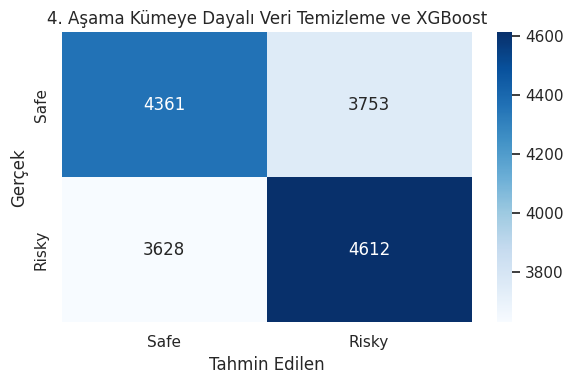

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Safe", "Risky"], yticklabels=["Safe", "Risky"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("4. Aşama Kümeye Dayalı Veri Temizleme ve XGBoost")
plt.tight_layout()
plt.show()

# Analiz Sonuçları

In [25]:
# Veri setinin yapısı
print("🔢 Veri boyutu:", df.shape)
print("\n Veri tipleri:")
print(df.dtypes)

print("\n Eksik değer sayıları:")
print(df.isnull().sum())

print("\n Benzersiz değer sayıları (ilk 15 sütun):")
print(df.nunique().head(15))

print("\n Örnek veri:")
display(df.head())

🔢 Veri boyutu: (67921, 38)

 Veri tipleri:
Timestamp                           object
Device_Type                         object
Malware_Detection                    int64
Phishing_Attempts                    int64
Social_Media_Usage                  object
VPN_Usage                            int64
Cyberbullying_Reports                int64
Parental_Control_Alerts              int64
Firewall_Logs                        int64
Login_Attempts                       int64
Download_Risk                        int64
Password_Strength                   object
Data_Breach_Notifications            int64
Online_Purchase_Risk                 int64
Education_Content_Usage             object
Age_Group                           object
Geolocation                         object
Public_Network_Usage                 int64
Network_Type                        object
Hours_Online                       float64
Website_Visits                       int64
Peer_Interactions                   object
Risky_Websi

,Timestamp,Device_Type,Malware_Detection,Phishing_Attempts,Social_Media_Usage,VPN_Usage,Cyberbullying_Reports,Parental_Control_Alerts,Firewall_Logs,Login_Attempts,...,Malware_Exposure_Risk,Cybersecurity_Behavior_Category,Weak_Password,High_Social_Media,Teenager,Risk_Index,Suspicious_Flag,Download_And_Purchase_Risk,VPN_WeakPW_Interaction,Social_Age_Cross
0,2017-01-01 00:00:00,Mobile,0,0,Low,0,0,0,4,2,...,1,Safe,1,0,1,1,0,0,1,0
1,2017-01-01 01:00:00,Desktop,0,0,Low,0,0,0,4,2,...,0,Neutral,1,0,1,1,0,0,1,0
2,2017-01-01 02:00:00,Laptop,0,0,Low,0,0,0,0,1,...,0,Neutral,0,0,1,1,0,0,0,0
3,2017-01-01 03:00:00,Mobile,0,0,Low,0,0,1,2,3,...,0,Safe,0,0,1,2,1,0,0,0
4,2017-01-01 04:00:00,Mobile,0,1,Medium,0,0,0,2,3,...,0,Risky,1,0,1,1,0,0,1,0


### Parola Gücü ve Risk Durumu (% oranlı Barplot)

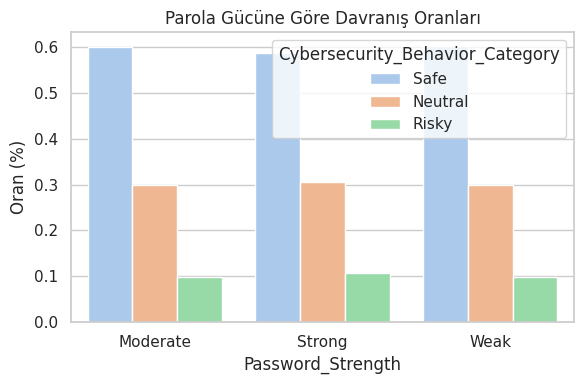

In [26]:
pw_dist = df.groupby("Password_Strength")["Cybersecurity_Behavior_Category"].value_counts(normalize=True).rename("Oran").reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=pw_dist, x="Password_Strength", y="Oran", hue="Cybersecurity_Behavior_Category", palette="pastel")
plt.title("Parola Gücüne Göre Davranış Oranları")
plt.ylabel("Oran (%)")
plt.tight_layout()
plt.show()

### VPN Kullanımı ve Davranış (Donut Chart)

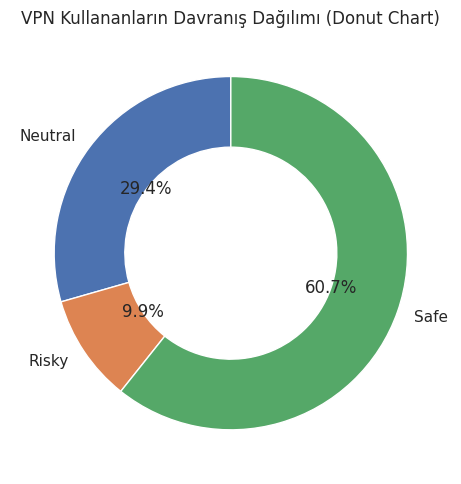

In [27]:
vpn_counts = df.groupby("VPN_Usage")["Cybersecurity_Behavior_Category"].value_counts().unstack().fillna(0)
vpn_counts = vpn_counts.loc[1]  # sadece VPN kullananlar

plt.figure(figsize=(5, 5))
plt.pie(vpn_counts, labels=vpn_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
plt.title("VPN Kullananların Davranış Dağılımı (Donut Chart)")
plt.tight_layout()
plt.show()

### Riskli Web Sitesi Ziyareti ile Davranış Arasındaki İlişki

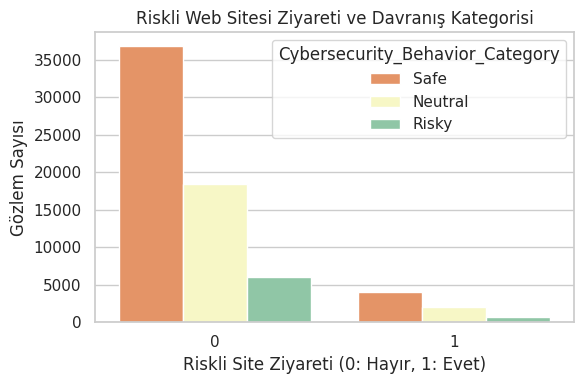

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Risky_Website_Visits", hue="Cybersecurity_Behavior_Category", palette="Spectral")
plt.title("Riskli Web Sitesi Ziyareti ve Davranış Kategorisi")
plt.xlabel("Riskli Site Ziyareti (0: Hayır, 1: Evet)")
plt.ylabel("Gözlem Sayısı")
plt.tight_layout()
plt.show()

### Sosyal Medya Kullanımı vs Davranış Kategorisi – Mozaik Grafik

<Figure size 700x500 with 0 Axes>

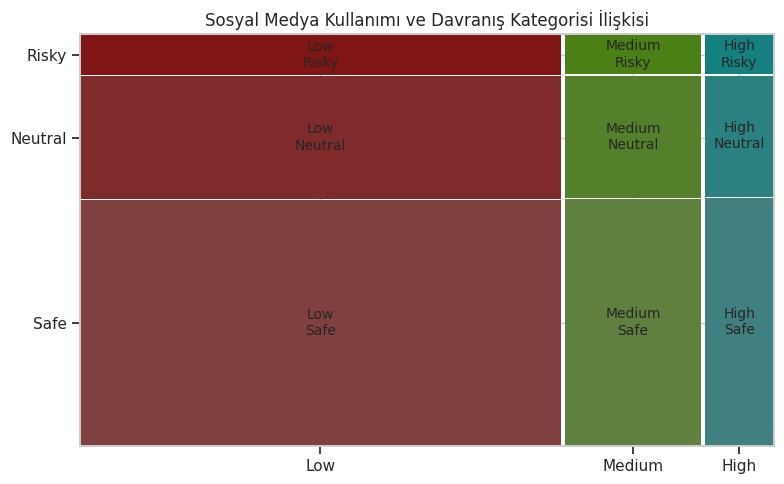

In [29]:
from statsmodels.graphics.mosaicplot import mosaic

plt.figure(figsize=(7, 5))
mosaic(df, ['Social_Media_Usage', 'Cybersecurity_Behavior_Category'])
plt.title("Sosyal Medya Kullanımı ve Davranış Kategorisi İlişkisi")
plt.tight_layout()
plt.show()

### Yaş Grubu Dağılımı – Pasta Grafik (pie chart)

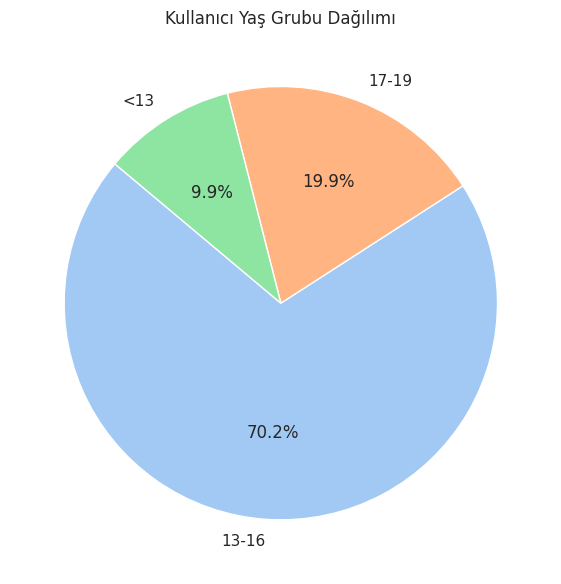

In [30]:
age_counts = df["Age_Group"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Kullanıcı Yaş Grubu Dağılımı")
plt.tight_layout()
plt.show()

### Eğitim İçeriği Kullanımı ve Risk Durumu (Horizontal Stacked Bar)

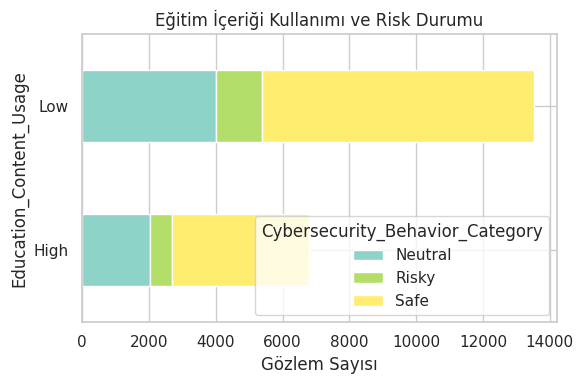

In [32]:
edu_counts = df[df['Education_Content_Usage'].notna()]
edu_dist = edu_counts.groupby("Education_Content_Usage")["Cybersecurity_Behavior_Category"].value_counts().unstack().fillna(0)

edu_dist.plot(kind="barh", stacked=True, colormap="Set3", figsize=(6, 4))
plt.title("Eğitim İçeriği Kullanımı ve Risk Durumu")
plt.xlabel("Gözlem Sayısı")
plt.tight_layout()
plt.show()

### Davranış Kategorilerine Göre En Riskli Özellikler – Heatmap (Risk Haritası)

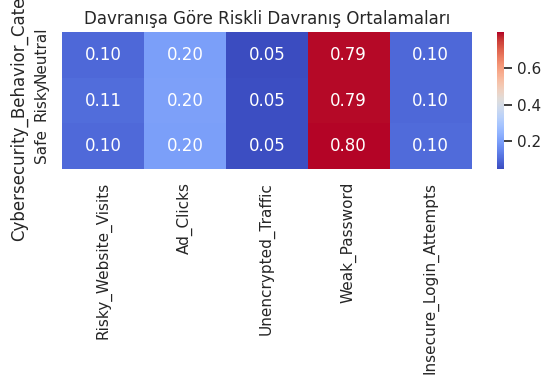

In [33]:
heat_data = df.groupby("Cybersecurity_Behavior_Category")[[
    "Risky_Website_Visits", "Ad_Clicks", "Unencrypted_Traffic",
    "Weak_Password", "Insecure_Login_Attempts"
]].mean()

plt.figure(figsize=(6, 4))
sns.heatmap(heat_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Davranışa Göre Riskli Davranış Ortalamaları")
plt.tight_layout()
plt.show()